This project builds an explainable deep learning model to classify chest X-ray images as **Normal** or **Pneumonia**, and visualizes its decision using **Grad-CAM** heatmaps. Built with PyTorch and deployed using Gradio.

---

## 📁 Project Structure

- Train a deep learning classifier (DenseNet121)
- Apply Grad-CAM for explainability
- Deploy as a Gradio web app
- Support small dataset with decent performance

Phase 1: Setup

- Environment: Google Colab (with GPU)
- Libraries: `torch`, `torchvision`, `matplotlib`, `cv2`, `gradio`
- Model: Pretrained `DenseNet121`


In [11]:
!pip install torch torchvision opencv-python numpy matplotlib streamlit -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [13]:
from google.colab import files
files.upload()  # Select your kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"godswilluzoechina","key":"0f801b44df00ad62b48e8c3843510d4c"}'}

Phase 2: Data Loading

- Dataset: Small version of [Chest X-ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)


In [14]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install kaggle -q

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

!unzip -q chest-xray-pneumonia.zip -d /content/


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:17<00:00, 224MB/s]
100% 2.29G/2.29G [00:17<00:00, 144MB/s]


In [15]:
import os

base_path = "/content/chest_xray"
print("Train folders:", os.listdir(os.path.join(base_path, "train")))
print("Val folders:", os.listdir(os.path.join(base_path, "val")))
print("Test folders:", os.listdir(os.path.join(base_path, "test")))


Train folders: ['NORMAL', 'PNEUMONIA']
Val folders: ['NORMAL', 'PNEUMONIA']
Test folders: ['NORMAL', 'PNEUMONIA']


##Phase 3: Model Training

- Model: Fine-tuned DenseNet121
- Binary classification (Pneumonia vs. Normal)
- Loss: `BCELoss` with sigmoid
- Optimizer: `Adam`
- Trained for 3–5 epochs


In [17]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_dir = "/content/chest_xray"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

train_subset, _ = random_split(train_data, [200, len(train_data)-200])
val_subset, _ = random_split(val_data, [50, len(val_data)-50])
test_subset, _ = random_split(test_data, [50, len(test_data)-50])

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=16)
test_loader = DataLoader(test_subset, batch_size=16)

print("Train batches:", len(train_loader))


Train batches: 13


In [18]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),
    nn.Sigmoid()
)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 85.2MB/s]


In [19]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, val_loader, epochs=3):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss/len(train_loader):.4f}")


        model.eval()
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = (outputs > 0.5).int()
                correct += (preds.view(-1) == labels).sum().item()
        acc = correct / len(val_loader.dataset)
        print(f"Validation Accuracy: {acc:.2f}")

train(model, train_loader, val_loader)


Epoch 1/3 - Train Loss: 0.5081
Validation Accuracy: 0.50
Epoch 2/3 - Train Loss: 0.4328
Validation Accuracy: 0.50
Epoch 3/3 - Train Loss: 0.3911
Validation Accuracy: 0.50


In [20]:
from collections import Counter

val_labels = [label for _, label in val_subset]
label_counts = Counter(val_labels)
print("Validation set class distribution:", label_counts)


Validation set class distribution: Counter({0: 8, 1: 8})


In [23]:
for param in model.features[-1].parameters():
    param.requires_grad = True


##Phase 4: Grad-CAM Visualization

- Registered forward & backward hooks on the last conv layer
- Computed activation × gradients to generate heatmap
- Overlay heatmap on the original image
- Visual output shows **regions influencing the prediction**

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

gradients = None
activations = None

def save_gradient(grad):
    global gradients
    gradients = grad

def generate_gradcam(image_tensor, model):
    global activations, gradients
    model.eval()


    def forward_hook(module, input, output):
        global activations
        activations = output
        output.register_hook(save_gradient)


    handle = model.features[-1].register_forward_hook(forward_hook)


    image_tensor = image_tensor.unsqueeze(0).to(device).requires_grad_(True)

    # Forward pass
    output = model(image_tensor)
    pred_class = (output > 0.5).int()

    # Backward pass
    model.zero_grad()
    output.backward(torch.ones_like(output))

    # Grad-CAM calculation
    pooled_grad = torch.mean(gradients, dim=[0, 2, 3])
    activation = activations.squeeze().detach().cpu().numpy()

    for i in range(len(pooled_grad)):
        activation[i, :, :] *= pooled_grad[i].item()

    heatmap = np.mean(activation, axis=0)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


    orig_img = image_tensor.squeeze().detach().cpu().permute(1, 2, 0).numpy()
    orig_img = orig_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    orig_img = np.clip(orig_img * 255.0, 0, 255).astype(np.uint8)


    superimposed = cv2.addWeighted(orig_img, 0.6, heatmap_color, 0.4, 0)

    handle.remove()
    return superimposed, pred_class.item()


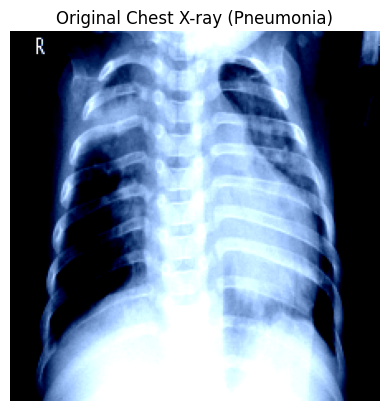

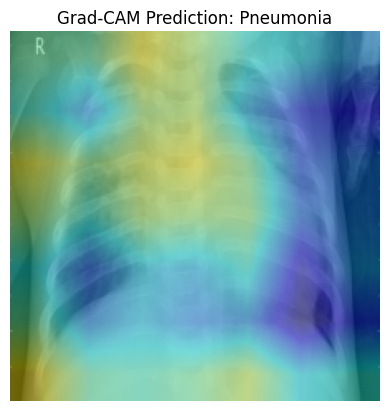

In [25]:
# Pick a pneumonia image (label=1) from test set
for img, label in test_subset:
    if label == 1:
        break

# Show original image
plt.imshow(img.permute(1, 2, 0))
plt.title("Original Chest X-ray (Pneumonia)")
plt.axis('off')
plt.show()

# Run Grad-CAM
gradcam_img, pred = generate_gradcam(img, model)

# Show result
plt.imshow(gradcam_img)
plt.title(f"Grad-CAM Prediction: {'Pneumonia' if pred else 'Normal'}")
plt.axis('off')
plt.show()


Phase 5: Gradio Deployment

- Simple web UI using Gradio
- User uploads a chest X-ray
- Model returns:
- Prediction: "Normal" or "Pneumonia"
- Grad-CAM heatmap image

```python
interface.launch(share=True)

In [27]:
!pip install -q gradio

import gradio as gr
from PIL import Image
import torchvision.transforms as T
import torch
import cv2
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

gradients = None
activations = None

def save_gradient(grad):
    global gradients
    gradients = grad

def generate_gradcam(image_tensor, model):
    global activations, gradients
    model.eval()

    def forward_hook(module, input, output):
        global activations
        activations = output
        output.register_hook(save_gradient)


    handle = model.features[-1].register_forward_hook(forward_hook)

    image_tensor = image_tensor.unsqueeze(0).to(device).requires_grad_(True)
    output = model(image_tensor)
    pred_class = (output > 0.5).int()

    model.zero_grad()
    output.backward(torch.ones_like(output))

    pooled_grad = torch.mean(gradients, dim=[0, 2, 3])
    activation = activations.squeeze().detach().cpu().numpy()
    for i in range(len(pooled_grad)):
        activation[i, :, :] *= pooled_grad[i].item()

    heatmap = np.mean(activation, axis=0)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    orig_img = image_tensor.squeeze().detach().cpu().permute(1, 2, 0).numpy()
    orig_img = orig_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    orig_img = np.clip(orig_img * 255.0, 0, 255).astype(np.uint8)

    superimposed = cv2.addWeighted(orig_img, 0.6, heatmap_color, 0.4, 0)
    handle.remove()
    return superimposed, pred_class.item()

def predict_pneumonia(img: Image.Image):
    img_tensor = transform(img).to(device)
    cam_img, pred = generate_gradcam(img_tensor, model)
    label = "PNEUMONIA DETECTED" if pred == 1 else "NORMAL"
    return label, Image.fromarray(cam_img)

interface = gr.Interface(
    fn=predict_pneumonia,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray"),
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Image(label="Grad-CAM Attention")
    ],
    title="🩻 Pneumonia Detection AI with Grad-CAM",
    description="Upload a chest X-ray. This AI model predicts pneumonia and highlights the image region influencing its decision.",
    examples=[],
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0d11e32c4fb72ba4f8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
